In [569]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.utilities import print_summary
import pandas as pd
import numpy as np
from datetime import datetime
import time
from firebase_admin import credentials
from firebase_admin import firestore
import firebase_admin
import pandas as pd
import json
# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

{'X_train': [[458700.88333333336], [458420.35], [457949.4], [458387.48333333334], [457343.05], [462297.26666666666], [456670.3], [457735.4666666667], [458380.6], [460276.7833333333], [458290.4166666667], [458445.6666666667], [457822.8], [457698.8333333333], [457916.2166666667], [463242.0833333333], [458445.6666666667], [463208.1666666667], [458285.15], [462305.3], [458387.48333333334], [463232.36666666664], [458087.5333333333], [461030.55], [461030.56666666665], [457961.1], [457708.9], [458298.11666666664], [457835.88333333336], [455926.9], [457899.85], [463208.11666666664], [462489.31666666665], [461774.7166666667], [459537.26666666666], [457759.48333333334], [463233.0333333333], [457949.4], [457836.75], [457759.48333333334], [458380.6]], 'Y_train': [[57.0], [42.0], [6.0], [100.0], [200.0], [1.0], [48.0], [150.0], [27.0], [52.0], [139.0], [69.0], [21.0], [50.0], [26.0], [5.0], [69.0], [14.0], [200.0], [21.0], [100.0], [6.0], [200.0], [4.0], [1.0], [25.0], [100.0], [57.0], [7.0], [21.0

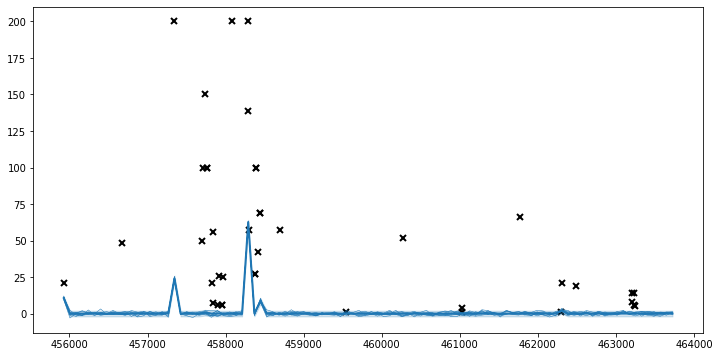

In [570]:
from flask import Flask
from flask import request
import pickle
import numpy as np
import pandas as pd
from datetime import datetime,date
## new 
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import tensorflow as tf
import gpflow
from firebase_admin import credentials
from firebase_admin import firestore
import firebase_admin
#import matplotlib.pyplot as plt
import firebase_admin
from firebase_admin import credentials
import json
import os

def get_day_26_mapping_model(date):
    import datetime
    new_date = []
    for m,d,y in zip(date.dt.month,date.dt.day,date.dt.year):
        #print(m,d,y)
        new_d = 0
        new_m = 0
        new_y = 0
        if d<=26:
            new_d = 26
            new_m = m
            new_y = y
        else:
            new_d = 26
            if m+1>12:
                new_d = 26
                new_m = 1
                new_y = y + 1
            else:
                new_d = 26
                new_m = m + 1
                new_y = y
        #print(d,m,y)
        #print(new_d,new_m,)
        new_date.append(datetime.datetime(new_y,new_m,new_d))
    return new_date
    

def gp_model():
    


    if not firebase_admin._apps:
        cred = credentials.Certificate('sim1-ac95f-firebase-adminsdk-3hy48-80b6b88451.json') 
        default_app = firebase_admin.initialize_app(cred)
    
    
    
    
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="sim1-ac95f-firebase-adminsdk-3hy48-80b6b88451.json"
    cred = r"sim1-ac95f-firebase-adminsdk-3hy48-80b6b88451.json"
    login = credentials.Certificate(cred)
    
    db = firestore.client()
    transaction = db.collection("Test").stream()

    
    dict_users = {"userid":[],"type":[], "amount":[],"time":[],"date":[]}
    
    count=0
    for trans in transaction:
        try:
            us = json.loads(str(trans.to_dict()).replace("'",'"').replace(" ","").lower())
            dict_users["userid"].append(us["userid"])
            dict_users["type"].append(us["type"])
            dict_users["amount"].append(us["amount"])
            dict_users["time"].append(us["time"])
            dict_users["date"].append(us["date"])
        except:
            continue
    ##
    df = pd.DataFrame.from_dict(dict_users)
    df = df[:53]
    
    ##
    #df = pd.read_csv('trans.csv') # when you add transcation to the dataset add them from the earliest to the latest so 0 should be the earliest transaction
    df["date"] = pd.to_datetime(df['date']+" "+df["time"],errors='coerce')
    df["amount"] = df["amount"].astype(float)
    df['day_26_mapping_date'] = get_day_26_mapping_model(df['date'])
    
    df = df.drop(df[(df.amount >= 1000)].index).reset_index()
    

    

    df['amount'] = tf.cast(df['amount'], tf.float64)
    condition = df["type"] == 'withdrawal'
    #df.loc[condition, ['amount']] *= -1
    
    for x in ['amount']:
        q75,q25 = np.percentile(df.loc[:,x],[75,25])
        intr_qr = q75-q25
     
        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)
     
        df.loc[df[x] < min,x] = np.nan
        df.loc[df[x] > max,x] = np.nan
    
    df = df.dropna(axis = 0)

    df["unix_date"] = [datetime.timestamp(dt)/3600 for dt in df["date"]]
    df["unix_date"] =tf.cast(df["unix_date"] , tf.float64)
    X = df[["unix_date"]]
    X = tf.cast(X, tf.float64) 
    
    Y = df[['amount']]
    Y = tf.cast(Y, tf.float64) 
    
    
    X_train = np.reshape(X,(-1, 1))
    Y_train = np.reshape(Y,(-1, 1))
    
    k = gpflow.kernels.RBF()
    m = gpflow.models.GPR(data=(X_train, Y_train), kernel=k, mean_function=None)
    #opt = gpflow.optimizers.Scipy()
    #opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=10000))
    
    
    #creating testing data
    last_trans = X.numpy().max()
    # mapping the last date of transaction to day_26_mapping_date column to get day 26
    day_26 = df[last_trans== df["unix_date"]]['day_26_mapping_date']

 
    # converting day_26 to the to unix timestamp
    day_26_unix_time = datetime.timestamp(pd.to_datetime(day_26.values[0]))/3600

    

    #generates points from the first transaction till  the nearst day 26 of the last transaction
    X_test = np.linspace(X.numpy().min(), day_26_unix_time , 100).reshape(100, 1) #doxum

    mean, var = m.predict_f(X_test)
    #generate 10 samples from posterior
    tf.random.set_seed(1)  # for reproducibility
    samples = m.predict_f_samples(X_test, 10)  # shape (10, 100, 1)
    #plot
    #X_train = numpy.array([[datetime.utcfromtimestamp(dt[0]*3600).strftime('%Y-%m-%d %H:%M:%S')] for dt in  X_train])

    #X_test = numpy.array([[datetime.utcfromtimestamp(dt[0]*3600).strftime('%Y-%m-%d %H:%M:%S')] for dt in  X_test])
    
    plt.figure(figsize=(12, 6))
    plt.plot(X_train, Y_train, "kx", mew=2)
    plt.plot(X_test, mean, "C0", lw=2)
    plt.fill_between(
        X_test[:, 0],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color="C0",
        alpha=0.2,
    )
    _=plt.plot(X_test, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
    

    pickle.dump(m, open('gp_model_test.pkl', 'wb'))
    return { "X_train":X_train.tolist(),
            "Y_train":Y_train.tolist(),
            "X_test":X_test.tolist(),
            "mean": mean.numpy().tolist()
            }
print(gp_model())

In [ ]:
dt = pd.to_datetime("20/03/2022"+" "+"21:52",errors='coerce')
dt = datetime.timestamp(dt)/3600
print(datetime.utcfromtimestamp(dt*3600).strftime('%Y-%m-%d %H:%M:%S'))



## Read the data from the firebase

In [502]:
import firebase_admin
from firebase_admin import credentials

if not firebase_admin._apps:
    cred = credentials.Certificate('sim1-ac95f-firebase-adminsdk-3hy48-80b6b88451.json') 
    default_app = firebase_admin.initialize_app(cred)


# firebase_admin.initialize_app(credential=None, options=None, name='[DEFAULT]')

In [527]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="sim1-ac95f-firebase-adminsdk-3hy48-80b6b88451.json"
cred = r"sim1-ac95f-firebase-adminsdk-3hy48-80b6b88451.json"
login = credentials.Certificate(cred)

In [528]:
db = firestore.client()
transaction = db.collection("Test").stream()

In [529]:
count

44

In [530]:
dict_users = {"userid":[],"type":[], "amount":[],"time":[],"date":[]}
# data_items = data_dict.items()
# data_list = list(data_items)

count=0
for trans in transaction:
    count = count+1
#     print(json.loads("{}".format(trans.to_dict())))
    try:
        us = json.loads(str(trans.to_dict()).replace("'",'"').replace(" ","").lower())
        dict_users["userid"].append(us["userid"])
        dict_users["type"].append(us["type"])
        dict_users["amount"].append(us["amount"])
        dict_users["time"].append(us["time"])
        dict_users["date"].append(us["date"])
    except:
        continue
        

In [531]:
df = pd.DataFrame.from_dict(dict_users)
df["date"] = pd.to_datetime(df['date']+" "+df["time"],errors='coerce')
df["amount"] = df["amount"].astype(float)
df.info()
print(len(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   userid  193 non-null    object        
 1   type    193 non-null    object        
 2   amount  193 non-null    float64       
 3   time    193 non-null    object        
 4   date    193 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 7.7+ KB
193


## Hnadling outliers

In [532]:
df = df.drop(df[(df.amount >= 1000)].index).reset_index()
df

,index,userid,type,amount,time,date
0,1,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,57.0,15:53,2022-04-30 15:53:00
1,2,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,500.0,11:17,2022-12-04 11:17:00
2,3,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,42.0,23:21,2022-04-18 23:21:00
3,4,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,400.0,13:33,2022-03-23 13:33:00
4,5,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,6.0,08:24,2022-03-30 08:24:00
...,...,...,...,...,...,...
185,188,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,41.0,17:39,2022-05-13 17:39:00
186,189,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,120.0,13:59,2022-12-05 13:59:00
187,190,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,300.0,21:47,2022-03-18 21:47:00
188,191,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,132.0,17:36,2022-02-05 17:36:00


In [533]:
df['amount'] = tf.cast(df['amount'], tf.float64)
condition = df["type"] == 'withdrawal'
#df.loc[condition, ['amount']] *= -1

for x in ["amount"]:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan
df = df.dropna(axis = 0)
df


,index,userid,type,amount,time,date
0,1,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,57.0,15:53,2022-04-30 15:53:00
2,3,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,42.0,23:21,2022-04-18 23:21:00
3,4,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,400.0,13:33,2022-03-23 13:33:00
4,5,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,6.0,08:24,2022-03-30 08:24:00
5,6,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,100.0,14:29,2022-04-17 14:29:00
...,...,...,...,...,...,...
185,188,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,41.0,17:39,2022-05-13 17:39:00
186,189,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,120.0,13:59,2022-12-05 13:59:00
187,190,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,300.0,21:47,2022-03-18 21:47:00
188,191,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,132.0,17:36,2022-02-05 17:36:00


In [534]:
#suggsted appraoch converting to unix timestamp
df["unix_date"] = [datetime.timestamp(dt)/3600 for dt in df["date"]]
df["unix_date"] =tf.cast(df["unix_date"] , tf.float64)
X = df[["unix_date"]]
X = tf.cast(X, tf.float64) 

<ipython-input-534-031013353e0e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unix_date"] = [datetime.timestamp(dt)/3600 for dt in df["date"]]
<ipython-input-534-031013353e0e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["unix_date"] =tf.cast(df["unix_date"] , tf.float64)


In [535]:
Y = df[['amount']]
Y = tf.cast(Y, tf.float64) 

In [536]:
#Create a mapping date for example if the date was 24/04/2022 the day26 that should be mapped to 26/04/2020
#27/04/2020 the day26 that should be mapped is 26/05/2020
#this will help us in creating the X_test see the cell bellow were I created X_test
def get_day_26_mapping(date):
    import datetime
    new_date = []
    for m,d,y in zip(date.dt.month,date.dt.day,date.dt.year):
        #print(m,d,y)
        new_d = 0
        new_m = 0
        new_y = 0
        if d<=26:
            new_d = 26
            new_m = m
            new_y = y
        else:
            new_d = 26
            if m+1>12:
                new_d = 26
                new_m = 1
                new_y = y + 1
            else:
                new_d = 26
                new_m = m + 1
                new_y = y
        new_date.append(datetime.datetime(new_y,new_m,new_d))
    return new_date

df['day_26_mapping_date'] = get_day_26_mapping(df['date'])
df

<ipython-input-536-6fd195ddd1df>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_26_mapping_date'] = get_day_26_mapping(df['date'])


,index,userid,type,amount,time,date,unix_date,day_26_mapping_date
0,1,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,57.0,15:53,2022-04-30 15:53:00,458700.883333,2022-05-26
2,3,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,42.0,23:21,2022-04-18 23:21:00,458420.350000,2022-04-26
3,4,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,400.0,13:33,2022-03-23 13:33:00,457786.550000,2022-03-26
4,5,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,6.0,08:24,2022-03-30 08:24:00,457949.400000,2022-04-26
5,6,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,100.0,14:29,2022-04-17 14:29:00,458387.483333,2022-04-26
...,...,...,...,...,...,...,...,...
185,188,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,41.0,17:39,2022-05-13 17:39:00,459014.650000,2022-05-26
186,189,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,120.0,13:59,2022-12-05 13:59:00,463954.983333,2022-12-26
187,190,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,300.0,21:47,2022-03-18 21:47:00,457674.783333,2022-03-26
188,191,cltv23dgcjy3i2eo956jxrxy2iy2,withdrawal,132.0,17:36,2022-02-05 17:36:00,456686.600000,2022-02-26


In [537]:
##testing the get_day_26_mapping
test_date = pd.Series(['2020-04-27 09:30'])
# Convert the underlying data to datetime 
test_date = pd.to_datetime(test_date)


print("2020-04-27 09:30 maps to:",get_day_26_mapping(test_date)[0])

test_date = pd.Series(['2020-04-24 23:30'])
# Convert the underlying data to datetime 
test_date = pd.to_datetime(test_date)

print("2020-04-24 23:30 maps to:",get_day_26_mapping(test_date)[0])

2020-04-27 09:30 maps to: 2020-05-26 00:00:00
2020-04-24 23:30 maps to: 2020-04-26 00:00:00


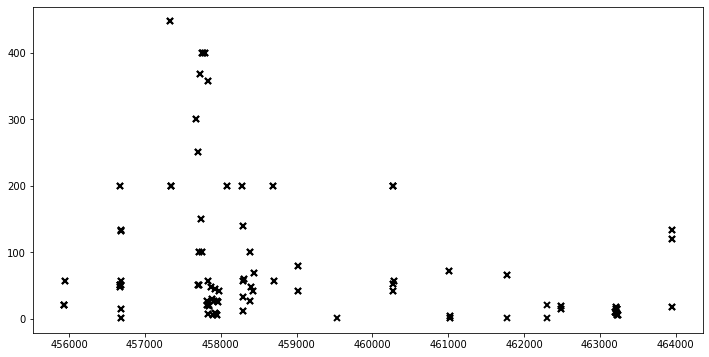

In [538]:
X_train = np.reshape(X,(-1, 1))
Y_train = np.reshape(Y,(-1, 1))


_ = plt.plot(X_train, Y_train, "kx", mew=2)

In [539]:
k = gpflow.kernels.RBF()

In [540]:
print(len(Y_train))
import numpy

print(len(Y_train[numpy.isfinite(Y_train)]))

169
169


In [541]:
m = gpflow.models.GPR(data=(X_train, Y_train), kernel=k, mean_function=None)

In [518]:
#opt = gpflow.optimizers.Scipy()
#opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=10000))

In [542]:
print_summary(m)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [543]:
#creating testing data
last_trans = X.numpy().max()

# mapping the last date of transaction to day_26_mapping_date column to get day 26
day_26 = df[last_trans== df["unix_date"]]['day_26_mapping_date']

print("Our last transction", pd.to_datetime(df[last_trans == df["unix_date"]]['date'].values[0]))
print("The nearest day 26 is:", pd.to_datetime(day_26.values[0]))

# converting day_26 to the summation appraoch
day_26_sum = day_26.dt.year+day_26.dt.month+day_26.dt.day+ 23 + 59 +59

# converting day_26 to the to unix timestamp
day_26_unix_time = datetime.timestamp(pd.to_datetime(day_26.values[0]))/3600

print("day_26 if we use the SUM appraoch: ",day_26_sum.values[0])
print("day_26 if we use the unix_time appraoch: ",day_26_unix_time)

#generates points from the first transaction till  the nearst day 26 of the last transaction
X_test = np.linspace(X.numpy().min(), day_26_unix_time , 100).reshape(100, 1) #doxum

Our last transction 2022-12-05 13:59:00
The nearest day 26 is: 2022-12-26 00:00:00
day_26 if we use the SUM appraoch:  2201
day_26 if we use the unix_time appraoch:  464445.0


In [544]:
mean

<tf.Tensor: shape=(100, 1), dtype=float64, numpy=
array([[1.50000000e+002],
       [0.00000000e+000],
       [7.94383465e-047],
       [3.17981296e-283],
       [2.54232943e+000],
       [4.67273754e-001],
       [0.00000000e+000],
       [0.00000000e+000],
       [1.42348452e-274],
       [1.79193392e-015],
       [6.42341058e-188],
       [4.70043367e+001],
       [4.16304532e-142],
       [5.26704395e-035],
       [1.00876514e-017],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [0.00000000e+000],
       [1.07058409e-076],
       [0.00000000e+000],
       [0.0000

In [545]:
# get the day in the last transaction X.iloc[-1]['date']
# Day_26 = day in last trans + ( day in last trans - 26 )
#In the system we should take Y= X(Day_26) #I explained in the code how to calculate Day_26
Day_26 = X[-1] + ( X[-1] - 26 )
Day_26

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([915824.66666667])>

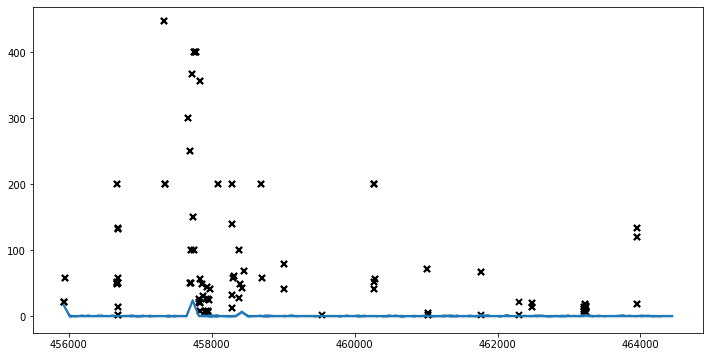

In [546]:
#generate test points for prediction
#predict mean and variance of latent GP at test points

mean, var = m.predict_f(X_test)

#generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(X_test, 10)  # shape (10, 100, 1)
#plot
plt.figure(figsize=(12, 6))
plt.plot(X_train, Y_train, "kx", mew=2)
plt.plot(X_test, mean, "C0", lw=2)
plt.fill_between(
    X_test[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0"
    alpha=0.2,
)
_=plt.plot(X_test, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)

In [226]:
#sum of prdedicted points
mean.numpy().sum()

-16.25703504553981

In [391]:
X_train

[['2022-04-30 12:53:00'],
 ['2022-04-18 20:21:00'],
 ['2022-03-23 10:33:00'],
 ['2022-03-30 05:24:00'],
 ['2022-04-17 11:29:00'],
 ['2022-03-04 23:03:00'],
 ['2022-09-27 09:16:00'],
 ['2022-02-04 22:18:00'],
 ['2022-03-21 07:28:00'],
 ['2022-04-17 04:36:00'],
 ['2022-07-05 04:47:00'],
 ['2022-04-13 10:25:00'],
 ['2022-04-19 21:40:00'],
 ['2022-03-24 22:48:00'],
 ['2022-03-19 18:50:00'],
 ['2022-03-28 20:13:00'],
 ['2022-11-05 18:05:00'],
 ['2022-03-22 10:17:00'],
 ['2022-04-19 21:40:00'],
 ['2022-11-04 08:10:00'],
 ['2022-04-13 05:09:00'],
 ['2022-09-27 17:18:00'],
 ['2022-04-17 11:29:00'],
 ['2022-11-05 08:22:00'],
 ['2022-04-04 23:32:00'],
 ['2022-08-05 14:33:00'],
 ['2022-08-05 14:34:00'],
 ['2022-03-30 17:06:00'],
 ['2022-03-20 04:54:00'],
 ['2022-03-25 09:37:00'],
 ['2022-04-13 18:07:00'],
 ['2022-03-25 11:53:00'],
 ['2022-01-04 22:54:00'],
 ['2022-03-28 03:51:00'],
 ['2022-11-04 08:07:00'],
 ['2022-10-05 09:19:00'],
 ['2022-09-05 14:43:00'],
 ['2022-06-04 09:16:00'],
 ['2022-03-2

In [390]:
X_train

array([[458700.88333333],
       [458420.35      ],
       [457786.55      ],
       [457949.4       ],
       [458387.48333333],
       [457343.05      ],
       [462297.26666667],
       [456670.3       ],
       [457735.46666667],
       [458380.6       ],
       [460276.78333333],
       [458290.41666667],
       [458445.66666667],
       [457822.8       ],
       [457698.83333333],
       [457916.21666667],
       [463242.08333333],
       [457762.28333333],
       [458445.66666667],
       [463208.16666667],
       [458285.15      ],
       [462305.3       ],
       [458387.48333333],
       [463232.36666667],
       [458087.53333333],
       [461030.55      ],
       [461030.56666667],
       [457961.1       ],
       [457708.9       ],
       [457833.61666667],
       [458298.11666667],
       [457835.88333333],
       [455926.9       ],
       [457899.85      ],
       [463208.11666667],
       [462489.31666667],
       [461774.71666667],
       [459537.26666667],
       [4577

In [38]:
#mean of prdedicted points
mean.numpy().mean()

-23.085279171823494

In [39]:
#the value of last point (aka day 26 23:59:59)
print(mean.numpy()[-1][0])

-8.633336079084321e-05


In [40]:
import pickle
pickle.dump(m, open('gp_model.pkl', 'wb'))